In [1]:
%pylab inline
import scipy
import sys
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils
from pyiga import assemble as Ass
from patchmesh import *
from patchmesh3D import *
import itertools as it
#from multipatch import *

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rref(A, tol=1e-8):
    B=A.astype(float).copy()
    m,n=B.shape
    rows=np.arange(m)
    i=0
    j=0
    piv=[]  #indices of pivot columns, rank = length(piv)
    while (i<m and j<n):
        k = np.argmax(abs(B[i:m,j]))
        k=k+i
        if abs(B[k,j])<=tol:
            B[i:m,j]=0
            j+=1
        else:
            piv.append(j)
            if k!=i:
                rows[[i,k]]=rows[[k,i]]
                B[[i,k],j:n]=B[[k,i],j:n]
            B[i,j:n]=B[i,j:n]/B[i,j]
            for l in np.r_[np.arange(i),np.arange(i+1,m)]:
                B[l,j:n]=B[l,j:n]-B[l,j]*B[i,j:n]
            i+=1
            j+=1
    return B, np.array(piv), rows

In [3]:
def basis_for_nullspace_of_dense_SVD(constr):
    '''Derives a matrix representing a basis for the nullspace of a dense matrix using SVD'''
    result = scipy.linalg.null_space(constr)
    # Scaling: Largest entry should be 1
    for i in range(result.shape[1]):
        mx = result[:,i].max()
        mn = result[:,i].min()
        if mx > -mx:
            result[:,i] /= mx
        else:
            result[:,i] /= mn
    return result.transpose()

def basis_for_nullspace_of_dense_LU(constr, tol=1e-8):
    '''Derives a matrix representing a basis for the nullspace of a dense matrix using LU'''
    #P,L,U = scipy.linalg.lu(constr)
    U, piv, _ = rref(constr, tol=tol)
    # Remove (almost) empty rows
    U=U[:len(piv),:]
    r,c = U.shape
    #print(U)
    # Swap cols if necessary
    perm = np.arange(c)
    for i in range(len(piv)):
        perm[[i,piv[i]]]=perm[[piv[i],i]]
#     for i in range(r):
#         if abs(U[i,i])<tol:
#             #mx = np.abs(U[i,i+1:]).max()
#             j = i
#             while abs(U[i,j]) < tol:
#                  j += 1
# #             j=i
# #             while abs(U[i,j])<tol:
# #                 j+=1
#             perm[i], perm[j] = perm[j], perm[i]
#             U[:,[i,j]] = U[:,[j,i]]
    # Split matrix U and resolve linear system
    #print(U)
    U1 = U[:,piv]
    U2 = U[:,perm[len(piv):]]
    #print(U1)
    #sol = scipy.linalg.lu_solve((U1,np.arange(r)),U2)
    # Setup result
    result = np.zeros((c,c-r))
    result[:r,:] = -U2
    result[r:,:] = np.eye(c-r)    
    # Apply perm
    result2=result.copy()
    result[list(perm)] = result2
    # Scaling: Largest entry should be 1
    for i in range(result.shape[1]):
        mx = result[:,i].max()
        mn = result[:,i].min()
        if mx > -mx:
            result[:,i] /= mx
        else:
            result[:,i] /= mn
    #R, piv, row_exchanges = rref(result.T)
    return result.T

def get_connected_components(constr):
    '''Derives all connected components of the graph, where cols of matrix are nodes'''
    assert isinstance(constr, scipy.sparse.csr_matrix)
    (r, c) = constr.shape
    
    if not constr.has_sorted_indices:
        constr.sort_indices()
    
    comps = np.arange(c)
    for i in range(r):
        smallest_index = c
        for j in range(constr.indptr[i], constr.indptr[i+1]):
            smallest_index = min(smallest_index, comps[constr.indices[j]])
        for j in range(constr.indptr[i], constr.indptr[i+1]):
            idx=comps[constr.indices[j]]
            comps[constr.indices[j]]=smallest_index
            while comps[idx]>smallest_index:
                idx_new=comps[idx]
                comps[idx] = smallest_index
                idx=comps[idx_new]
    
    for i in range(c):
        if comps[comps[i]] < comps[i]:
            comps[i] = comps[comps[i]]
        
    constr_list = {}
    for i in range(r):
        comp = comps[constr.indices[constr.indptr[i]]]
        if comp not in constr_list:
            constr_list[comp] = []         
        constr_list[comp].append(i)
        
    comp_list = {}
    coupled = np.zeros(c,'b')
    for i in range(c):
        comp = comps[i]
        if comp != i or comp in constr_list.keys():
            if not comp in comp_list:
                comp_list[comp] = [comp]
            if comp != i:
                comp_list[comp].append(i)
            coupled[i] = True
    
#     print("coupled     =",coupled)
#     print("comp_list   =",comp_list)
#     print("constr_list =",constr_list)
    
    return coupled, comp_list, constr_list

def basis_for_nullspace(constr, basis_for_nullspace_of_dense=basis_for_nullspace_of_dense_SVD):
    '''Derives a matrix representing a basis for the nullspace of a sparse matrix by first decomposing it into its connected components'''
    assert isinstance(constr, scipy.sparse.csr_matrix)
    (r, c) = constr.shape
    
    coupled, comp_list, constr_list = get_connected_components(constr)

    mat = scipy.sparse.lil_matrix((c,c))
    
    # First, take the free dofs as they are
    row = 0
    for i in range(c):
        if not coupled[i]:
            mat[row,i] = 1
            row += 1

    # TODO: Secondly, take the dofs with one-to-one mapping
    
    # Finally, take the other dofs
    for i in comp_list.keys():
        comp_item = comp_list[i]
        constr_item = constr_list[i]
        local_matrix = (constr[constr_item,:][:,comp_item]).A
        #print(local_matrix)
        local_basis  = basis_for_nullspace_of_dense(local_matrix)
        #print(local_basis)
        #print( "local_matrix:\n", local_matrix )
        #print( "local_basis :\n", local_basis  )
        lb_rows, lb_cols = local_basis.shape
        for i0 in range(lb_rows):
            for j0 in range(lb_cols):
                mat[row,comp_item[j0]] = local_basis[i0,j0]
            row += 1

    mat.resize(row,c)
    return mat.tocsr()

In [4]:
def PoissonEstimator(MP,f,uh):
    n = MP.mesh.numpatches
    indicator = np.zeros(n)
    params = {'f': f}
    
    uh_per_patch = dict()
    
    #residual contribution
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        
        h = np.linalg.norm([b-a for a,b in geo.bounding_box()])
        
        N = tuple(kv.numdofs for kv in kvs)
        uh_per_patch[p] = (MP.global_to_patch(p) @ uh).reshape(N)   #cache Spline Function on patch p
        
        params['geo'] = geo
        params['uh_func'] = geometry.BSplineFunc(kvs, uh_per_patch[p])
        
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        indicator[p] = h**2 * np.sum(Ass.assemble('(f + div(grad(uh_func)))**2 * v * dx', kvs0, params))
        
    params = dict()
    
    #flux contribution
    for i,((p1,b1,_), (p2,b2,_), _, flip) in enumerate(MP.intfs):
        #print(p1, p2, flip)
        
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = Ass.int_to_bdspec(b1), Ass.int_to_bdspec(b2)
        
        bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)

        geo = geo2.boundary(bdspec2)
        params['geo'] = geo
        
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        h = np.sum(Ass.assemble('v * ds', kv0, params))
        
        params['uh_grad1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        params['uh_grad2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        #params['uh1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).boundary(bdspec1,flip=flip)
        #params['uh2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).boundary(bdspec2)
        normalflux_jump = np.sum(Ass.assemble('(inner(uh_grad1 - uh_grad2, n) )**2 * v * ds', kv0 ,params))
        #print(normalflux_jump)

        indicator[p1] += 0.5 * h * normalflux_jump
        indicator[p2] += 0.5 * h * normalflux_jump
    
    return np.sqrt(indicator)

def check_coupling(MP, u_):
    u_pp = dict()

    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1,_),_), ((kvs2,_),_) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = int_to_bdspec(b1), int_to_bdspec(b2)
        (kv1), (kv2) = boundary_kv(kvs1, bdspec1), boundary_kv(kvs2, bdspec2, flip=flip)
        dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel=True), Ass.boundary_dofs(kvs2, bdspec2, ravel=True, flip=flip)
        
        if p1 not in u_pp:
            u_pp[p1]=MP.global_to_patch(p1) @ u_
        if p2 not in u_pp:
            u_pp[p2]=MP.global_to_patch(p2) @ u_
          
        P = bspline.prolongation(kv1, kv2)
        u1, u2 = u_pp[p1][dofs1], u_pp[p2][dofs2]
        r=norm(u2 - P @ u1)
        
        if r>1e-8:
            return False
    return True

class Multipatch:
    """Represents a multipatch structure, consisting of a number of patches
    together with their discretizations and the information about shared dofs
    between patches. Nonconforming patches (both geometrically and knotwise non conforming) are allowed as long as there exists 
    a hierarchy between the interface knots

    Args:
        pm: A :class:`PatchMesh` instance representing the patches 
            via their discretization and their geometry function 
            as well as the generated mesh between the patches (vertices, interfaces).
            
        b_data: A dictionary of the form {'D':dir_data, 'N':neu_data, 'R': robin_data}
            dir_data: A list of triples (patch, bdspec, dir_func) prescribing the function `dir_func` to boundary dofs of `patch` on side `bdspec`.
            neu_data: A list of triples (patch, bdspec, neu_func) in order to assemble natural boundary conditions for boundary dofs of `patch` on side `bdspec`.
            robin_data: A list of triples (patch, bd_spec, (gamma, robin_func))
        
        automatch (bool): if True, attempt to automatically apply the interface information from the PatchMesh object to couple the patches.
            If False, the user has to manually join the patches by calling
            :meth:`join_boundaries` as often as needed, followed by
            :meth:`finalize`.
    """
    def __init__(self, pm, automatch=False, dim=2):
        """Initialize a multipatch structure."""
        # underlying PatchMesh object describing the geometry
        self.mesh = pm
        # enforced regularity across patch interfaces
        #self.k = k
        self.dim = dim 
            
        # number of tensor product dofs per patch
        self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod(n) for n in self.n]
        # offset to the dofs of the i-th patch
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # per patch, a dict of shared indices
        self.shared_pp = dict(zip([p for p in range(self.mesh.numpatches)],self.mesh.numpatches*[set(),]))
        # a list of interfaces (patch1, boundary dofs1, patch2, boundary dofs2)
        self.intfs = set()
        self.Constr=scipy.sparse.csr_matrix((0,self.N_ofs[-1]))
        self.dof_class={dof:0 for dof in np.arange(self.N_ofs[-1])}

        if automatch:
            interfaces = self.mesh.interfaces.copy()
            
            for ((p1,bd1,s1),((p2,bd2,s2),flip)) in interfaces.items():
                if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                    self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
                
            #print(self.intfs)
            for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs:
                bdspec1 = (Ass.int_to_bdspec(bd1),)
                bdspec2 = (Ass.int_to_bdspec(bd2),)
                self.join_boundaries(p1, bdspec1, s1 , p2, bdspec2, s2, flip)
            #self.finalize()

    @property
    def numpatches(self):
        """Number of patches in the multipatch structure."""
        return len(self.mesh.patches)

    @property
    def numdofs(self):
        """Number of dofs after eliminating shared dofs.

        May only be called after :func:`finalize`.
        """
        return self.Basis.shape[0]
    
    @property
    def numloc_dofs(self):
        return self.N_ofs[-1]
    
    def reset(self, automatch = False):
        self.__init__(pm=self.mesh, b_data=self.b_data, dim=self.dim, automatch=automatch)

    def join_boundaries(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.dim-1)*(False,)
        
        bkv1 = Ass.boundary_kv(kvs1, bdspec1)
        bkv2 = Ass.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = Ass.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = Ass.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):          
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
        else:
            print('interface coupling not possible')
            
        for dof in dofs1:
            if self.dof_class[dof + self.N_ofs[p1]]==0:
                self.dof_class[dof + self.N_ofs[p1]]=1
        for dof in dofs2:
            self.dof_class[dof + self.N_ofs[p2]]=2
            
        self.shared_pp[p1]=self.shared_pp[p1] | set(dofs1)
        self.shared_pp[p2]=self.shared_pp[p2] | set(dofs2)
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make paramater to generate prolongation matrix as coo_matrix directly?
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        
        self.Constr = scipy.sparse.vstack([self.Constr,scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.numloc_dofs)).tocsr()])
        
           
    def finalize(self):
        """After all shared dofs have been declared using
        :meth:`join_boundaries` or :meth:`join_dofs`, call this function to set
        up the internal data structures.
        """
        num_shared = [len(self.shared_pp[p]) for p in range(self.numpatches)]
        # number of local dofs per patch
        self.M = [n - s for (n, s) in zip(self.N, num_shared)]
        # local-to-global offset per patch
        self.M_ofs = np.concatenate(([0], np.cumsum(self.M)))
        #TODO: self.Basis = basis_for_nullspace(self.Constr, basis_for_nullspace_of_dense_LU, idx=self.dof_class)
        #self.sanity_check()   

    def assemble_system(self, problem, rhs, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        """Assemble both the system matrix and the right-hand side vector
        for a variational problem over the multipatch geometry.

        Here `problem` represents a bilinear form and `rhs` a linear functional.
        See :func:`assemble` for the precise meaning of the arguments.

        Returns:
            A pair `(A, b)` consisting of the sparse system matrix and the
            right-hand side vector.
        """
        n = self.numdofs
        X=MP.Basis
        
        A = []
        b = []
        if args is None:
            args = dict()
        for p in range(self.numpatches):
            kvs, geo = self.mesh.patches[p][0]
            args.update(geo=geo)
            # TODO: vector-valued problems
            A.append(Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs))
    
            b.append(Ass.assemble(rhs, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs).ravel())
        A = X@scipy.sparse.block_diag(A)@X.T
        b = X@np.concatenate(b)
            
        return A, b
    
    def assemble_surface(self, problem, arity=1, boundary_idx=0, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        X = MP.Basis
        if args is None:
            args = dict()
        if arity==2:
            I, J, data = [], [], []
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
                
                R = Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format='coo', layout=layout,
                        **kwargs, boundary=bdspec)
                
                I_p ,J_p = R.row, R.col
                I.append(bdofs[I_p]), J.append(bdofs[J_p]), data.append(R.data)
                
            I, J, data = np.concatenate(I), np.concatenate(J), np.concatenate(data)
            R = scipy.sparse.coo_matrix((data, (I, J)), 2*(self.numloc_dofs,))
            return X @ scipy.sparse.csr_matrix(R) @ X.T
        else:
            N=np.zeros(self.numloc_dofs)
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
    
                vals=Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec).ravel()
                N[bdofs] += vals 
            
            return X @ N
            
    
#     def assemble_boundary(self, problem, boundary_idx = None, args=None, bfuns=None,
#             symmetric=False, format='csr', layout='blocked', **kwargs):
        
    
#     def C1_coupling(self, p1, bdspec1, p2, bdspec2, flip=None):
        
#         (ax1, sd1), (ax2, sd2) = bdspec1, bdspec2
#         ((kvs1, geo1),_), ((kvs2, geo2),_) = self.mesh.patches[p1], self.mesh.patches[p2]
#         sup1, sup2 = geo1.support, geo2.support
#         dim=len(kvs1)
#         if flip is None:
#             flip=(dim-1)*(False,)
 
#         bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)
#         dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel = True, k=1), Ass.boundary_dofs(kvs2, bdspec2, ravel = True, flip=flip, k=1)
#         G = tuple(kv.greville() for kv in kvs2)
#         G2 = G[:ax2] + (np.array([sup2[ax2][0] if sd2==0 else sup2[ax2][-1]]),) + G[ax2+1:]
#         G1 = G[:ax2] + G[ax2+1:]
#         G1 = G1[:ax1] + (np.array([sup1[ax1][0] if sd1==0 else sup1[ax1][-1]]),) + G1[ax1:] #still need to add flip

#         M=tuple(len(g) for g in G2)
#         m=np.prod(M)
#         n1,n2=len(dofs1), len(dofs2)
        
#         C1, D1 = bspline.collocation_derivs_tp(kvs1, G1, derivs=1)
#         C2, D2 = bspline.collocation_derivs_tp(kvs2, G2, derivs=1)
    
#         C1, C2 = C1[0].tocsr()[:,dofs1], C2[0].tocsr()[:,dofs2]
#         for i in range(dim):
#             D1[i], D2[i] = D1[i].tocsr()[:,dofs1], D2[i].tocsr()[:,dofs2]
#         N2=geo2.boundary(bdspec2).grid_outer_normal(G2[:ax2]+G2[ax2+1:]).reshape(m,dim)

#         J1=geo1.grid_jacobian(G1).reshape(m,dim,dim)
#         J2=geo2.grid_jacobian(G2).reshape(m,dim,dim)
        
#         invJ1=np.array([inv(jac) for jac in J1[:]])
#         invJ2=np.array([inv(jac) for jac in J2[:]])

#         NC1=scipy.sparse.csr_matrix((m, n1))
#         for i in range(dim):
#             NC1_ = scipy.sparse.csr_matrix((m, n1))
#             for j in range(dim):
#                 NC1_ += scipy.sparse.spdiags(invJ1[:,i,j], 0, m, m)*D1[dim-1-j]
#             NC1 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC1_
            
#         NC2=scipy.sparse.csr_matrix((m, n2))
#         for i in range(dim):
#             NC2_ = scipy.sparse.csr_matrix((m, n2))
#             for j in range(dim):
#                 NC2_ += scipy.sparse.spdiags(invJ2[:,i,j], 0, m, m)*D2[dim-1-j]
#             NC2 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC2_
            
#         A = scipy.sparse.vstack([C1, NC1])
#         B = scipy.sparse.vstack([C2, NC2])
#         P = scipy.sparse.linalg.spsolve(B,A.A)
#         # prune matrix
#         P[np.abs(P) < 1e-15] = 0.0
#         return scipy.sparse.csr_matrix(P) 
        
    def L2Projection(self, u):
        M, rhs, _, _, _ = self.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)
        u_ = solvers.make_solver(M, spd=True).dot(rhs)
        return u_
    
    def refine(self, patches=None, mult=1, return_prol=False):
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
            patches = patches.keys()
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
        elif patches==None:
            patches = np.arange(self.numpatches)
        elif np.isscalar(patches):
            patches=(patches,)
        else:
            assert 0, "unknown input type"
        if return_prol:
            n=self.numdofs
            old_kvs=[kvs for (kvs,_),_ in self.mesh.patches]
            old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
            
        self.mesh.refine(patches, mult=mult)
        self.reset(automatch=True)
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        
        if return_prol:
            m = self.numdofs
            P = scipy.sparse.csr_matrix((m, n))
            
            for p in range(self.numpatches):
                if p in patches:
                    kvs=old_kvs[p]
                    new_kvs=MP.mesh.patches[p][0][0]
                    C = bspline.prolongation_tp(kvs, new_kvs)
                else:
                    C = scipy.sparse.identity(self.N[p])

                P += MP.patch_to_global(p) @ C @ old_global_to_patch[p]
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in MP.shared_dofs]
            P[MP.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[MP.M_ofs[-1]:]
            return P
        
    def patch_refine(self, patches=None, mult=1, return_prol = False):
        """Refines the Mesh by splitting patches
        
        The dictionary `patches` specifies which patches (dict keys) are to be split 
        and how to split them (dict values: 0 to dim-1 or None)
        
        The `return_prol` keyword enables also the generation of a prolongation matrix from one mesh to the split mesh.
        
        Returns:
            A new :class:`Multipatch` object `MP`
            A sparse matrix `P` suitable for prolongation.
        """
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
        elif isinstance(patches,int):
            #assert patches >=0 and patches < self.dim, "dimension error."
            patches = {p:patches for p in range(self.numpatches)}
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
            patches = {p:None for p in patches}
        elif patches==None:
            patches = {p:None for p in range(self.numpatches)}
        else:
            assert 0, "unknown input type"
        
        #n=self.numdofs
        N=self.numpatches

        #M = copy.deepcopy(self.mesh)
        #old_kvs = [kvs for (kvs,_),_ in self.mesh.patches]
       # old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
        
        new_patches = dict()
        new_kvs_ = dict()
        for p in patches.keys():
            self.split_boundary_data(p, self.numpatches, axis=patches[p])
            new_patches[p], new_kvs_[p] = self.mesh.split_patch(p, axis=patches[p], mult=mult)
        
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        self.reset(automatch=True)
        #m = self.numdofs
        
        if return_prol:
            P = scipy.sparse.csr_matrix((m, n))
            for p in range(N):
                kvs=old_kvs[p]
                if p in new_patches:
                    new_kvs = new_kvs_[p]
                    S = scipy.sparse.csr_matrix((m,bspline.numdofs(new_kvs)))
                    C =  bspline.prolongation_tp(kvs, new_kvs)
                    
                    for i, new_p in enumerate(new_patches[p]):
                    
                        val = np.ones(self.N[new_p])
                        I = np.arange(self.N[new_p])
                        
                        if patches[p]==0:
                            bdspec = (0,i)
                            k = self.mesh.patches[new_p][0][0][0].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        elif patches[p]==1:
                            bdspec = (1,i)
                            k = self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
                        else:
                            cspec=(i//2,i%2)
                            k0=self.mesh.patches[new_p][0][0][0].numdofs
                            k1=self.mesh.patches[new_p][0][0][1].numdofs
                            J = np.sort(Ass.boundary_dofs(new_kvs,cspec,k=[k0-1,k1-1], ravel=True))
               
                        R = scipy.sparse.coo_matrix((val,(I,J)),shape=(self.N[new_p],bspline.numdofs(new_kvs)))
                        S += self.patch_to_global(new_p) @ R
                else:
                    S=self.patch_to_global(p)
                    C=scipy.sparse.identity(self.N[p])
                
                P += S @ C @ old_global_to_patch[p]
                
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in self.shared_dofs]
            P[self.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[self.M_ofs[-1]:]
            return P
        
#     def split_boundary_data(self, p, n, axis = None):
#         """Splits the boundary information of a patch `p`.
    
#         Args:
#             p: patch to be split
#             n: total number of patches
#             dir_data: information of the Dirichlet condition over the whole PatchMesh structure
            
#         Returns:
#             Modified list `dir_data` with split patches.
#         """
#         if axis==None:
#             axis=tuple(range(self.dim))
#         axis=np.unique(axis)
#         if len(axis)==1: axis=axis[0]
#         for s in self.b_data.keys():
            
#             b_data_p = [(patch , bd, g) for (patch, bd, g) in self.b_data[s] if patch == p]
            
#             if b_data_p:
#                 if not np.isscalar(axis):
#                     for k,ax in enumerate(axis[::-1]):
#                         self.split_boundary_data(p, n+2**k-1, axis=ax)
#                         for i in range(2**k-1):
#                             self.split_boundary_data(n+i, n+2**k+i, axis=ax)
#                 else:
#                     for (patch, bd, g) in b_data_p:
#                         if self.dim==3:
#                             if axis == self.dim - 3:
#                                 if bd == 'back':
#                                     self.b_data[s].remove((patch, bd, g))
#                                     self.b_data[s].append((n, bd, g))
#                                 if bd == 'left' or bd == 'right' or bd == 'bottom' or bd=='top':
#                                     self.b_data[s].append((n, bd, g))
#                         if axis == self.dim - 2:
#                             if bd == 'top':
#                                 self.b_data[s].remove((patch, bd, g))
#                                 self.b_data[s].append((n, bd, g))
#                             if bd == 'left' or bd == 'right':
#                                 self.b_data[s].append((n, bd, g))
#                             if self.dim == 3:
#                                 if bd == 'front' or bd == 'back':
#                                     self.b_data[s].append((n, bd, g)) 
#                         if axis == self.dim - 1:
#                             if bd == 'right':
#                                 self.b_data[s].remove((patch, bd, g))
#                                 self.b_data[s].append((n, bd, g))   
#                             if bd == 'bottom' or bd == 'top':
#                                 self.b_data[s].append((n, bd, g))
#                             if self.dim == 3:
#                                 if bd == 'front' or bd == 'back':
#                                     self.b_data[s].append((n, bd, g)) 

    def compute_dirichlet_bcs(self):
        """Performs the same operation as the global function
        :func:`compute_dirichlet_bcs`, but for a multipatch problem.

        The sequence `dir_data` should contain triples of the form `(patch,
        bdspec, dir_func)`.

        Returns:
            A pair `(indices, values)` suitable for passing to
            :class:`RestrictedLinearSystem`.
        """
        bcs = []
        p2g = dict()        # cache the patch-to-global indices for efficiency
        for (p, bdspec, g) in self.b_data['D']:
            (kvs, geo), _ = self.mesh.patches[p]
            bc = Ass.compute_dirichlet_bc(kvs, geo, bdspec, g)
            if p not in p2g:
                p2g[p] = self.patch_to_global_idx(p)
            idx = p2g[p]    # maps local dofs to global dofs
            bcs.append((*idx[bc[0],0].toarray().T, bc[1]))
        return Ass.combine_bcs(bcs)
    
    def sanity_check(self):
        for p in range(self.numpatches):
            assert all([np.isclose(sum(coeffs),1.0) for _,coeffs in self.shared_per_patch[p].values()]), 'coupling of dofs is flawed'

In [472]:
def elim_cycle(Constr, activeConstraints):
    derivedDofs={}
    for r in activeConstraints:
        dofToBeEliminated = -1
        feasible = True
        mx=0
        for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
            c = Constr.indices[ind]
            v = Constr.data[ind]
            
            if v > 1e-12: # We know that there is only one (see assertion above!)
                # if dofToBeEliminated<0:
                #     dofToBeEliminated=c
                if dofToBeEliminated >0:
                    if v>mx:
                        dofToBeEliminated=c
                        mx=v
                else:
                    dofToBeEliminated = c
                    mx=v
        if dofToBeEliminated == -1: # Empty row (TODO: check)
            feasible = False
        for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
            c = Constr.indices[ind]
            v = Constr.data[ind]
            if v < -1e-12 and c in derivedDofs:
                #print("{} cannot be eliminated (constraint #{}) because it refers to eliminated dof {}.".format(dofToBeEliminated,r,c))
                feasible = False
        if dofToBeEliminated in derivedDofs:
            #print("{} cannot be eliminated (constraint #{}) because it is already eliminated.".format(dofToBeEliminated,r))
            feasible = False
        if feasible:
            #print(dofToBeEliminated)
            derivedDofs[dofToBeEliminated] = r
    # for i, _ in derivedDofs.items():
    #     print(i, end=', ')
    return derivedDofs

In [473]:
def create_cycle_basis(Constr, derivedDofs, Basis):
    n=Constr.shape[1]
    testVec = np.zeros(n)
    #print(Basis)
    
#variant 1
#     lBasis = scipy.sparse.lil_matrix((n,n)) #coo_matrix ?
#     for i in range(n):
#         if not i in derivedDofs:
#             lBasis[i,i] = 1

#     for i, r in derivedDofs.items():
#         for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
#             c = Constr.indices[ind]
#             v = Constr.data[ind]    
#             if v < -1e-12:
#                 lBasis[i,c] = - v / Constr[r,i]
    
#fast variant
    ddofs=np.array(list(derivedDofs.keys()))   #derived dofs
    #print(ddofs.dtype)
    n2 = len(ddofs)
    r = np.array(list(derivedDofs.values()))  #which constraints do the dofs derive from
    nddofs=np.setdiff1d(np.arange(n),ddofs)   #still free dofs
    n1=len(nddofs)

    lBasis=scipy.sparse.csr_matrix((n,n))
    c = 1/(Constr[r,ddofs].A.ravel())
    B1 = scipy.sparse.csr_matrix(scipy.sparse.coo_matrix((np.ones(n1),(np.arange(n1),nddofs)),(n1,n)))
    B2 = - Constr[r].multiply(Constr[r]<0)
    B2 = scipy.sparse.spdiags(c,0,n2,n2)@B2  #row scaling
    
    Q1 = scipy.sparse.coo_matrix((np.ones(n1),(nddofs,np.arange(n1))),(n,n1))
    Q2 = scipy.sparse.coo_matrix((np.ones(n2),(ddofs,np.arange(n2))),(n,n2))
    lBasis = Q1@B1 + Q2@B2
    
    
    lBasis = lBasis @ Basis
    
    lastFound = n+1
    print(len(ddofs))
    testVec[ddofs]=1 
        
    while True:
        found = 0
        tmp = lBasis @ testVec
        # for i in range(n):
        #     if abs(tmp[i])>1e-12:
        #         #print('{}'.format(i))
        #         found += 1
        found = sum(abs(tmp)>1e-12)
        if found > 0:
            #print(found, lastFound)
            assert(found < lastFound)
            lastFound = found
            lBasis = lBasis @ lBasis
            print("multiply & repeat")
        else:
            print("done")
            break
    return lBasis

In [474]:
def compute_active_constr(Constr):
    #fast variant
    activeConstraints=[]
    a=(Constr>1e-12).sum(axis=1).A.ravel(); b=(Constr<-1e-12).sum(axis=1).A.ravel()
    activeConstraints=np.where(a+b>0)[0]
    
    signs=1.*((a<=1) | (a+b==0))-1.*((a>1)&(a+b>0))
    #print(signs)
    S=scipy.sparse.spdiags(signs,0,len(a),len(a))
    
    Constr[:] = S@Constr
    
    # assert np.all(((a[activeConstraints]==1) | (b[activeConstraints]==1))), 'error in constraint matrix.'

    #variant 1
    # for r in range(Constr.shape[0]):
    #     a = 0
    #     b = 0
    #     for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
    #         if Constr.data[ind] > 1e-12:
    #             a += 1
    #         if Constr.data[ind] < -1e-12:
    #             b += 1
    #     if a+b>0:
    #         activeConstraints.append(r)
    #         #print("{}: {}, {}".format(r,a,b))
    #         if not (a==1 or b==1): 
    #             #print(a,b)
    #             #print(Constr[r,:])
    #         #assert (a==1 or b==1), 'error in constraint matrix.'
    #         if a>1:
    #             print( "Re-sign" )
    #             Constr[r,:] *= -1
                
    return np.array(activeConstraints)

In [475]:
def compute_basis(Constr, maxiter):
    n=Constr.shape[1]
    allLocalDofs=np.arange(n)
    allderivedDofs={}
    activeConstraints=np.arange(Constr.shape[0])
    Basis=scipy.sparse.identity(n)
    i=1
    while len(activeConstraints)!=0:
        #print(Constr[activeConstraints])
        if i>maxiter:
            print("maxiter reached.")
            break
            
        derivedDofs = elim_cycle(Constr, activeConstraints)  
        allderivedDofs.update(derivedDofs)
        nonderivedDofs=np.setdiff1d(allLocalDofs, np.array(list(allderivedDofs.keys())))
        if not derivedDofs:
            return Basis, Constr[activeConstraints], nonderivedDofs
            break
        Basis = create_cycle_basis(Constr, derivedDofs, Basis)
        #print(Basis.data)
        Constr = Constr @ Basis    
        activeConstraints = compute_active_constr(Constr)
            
        i+=1
        
    #print(np.array(list(allderivedDofs.keys())))
    #nonderivedDofs=np.setdiff1d(allLocalDofs, np.array(list(allderivedDofs.keys())))
    #print(nonderivedDofs)
    return Basis[:,nonderivedDofs], Constr, nonderivedDofs

In [526]:
#Example 3D

#setup initial discretization 
deg = 1
N = 1
kvs = [3*(bspline.make_knots(deg,0.0,1.0,N),),]

# define geometry
geos = [
    geometry.unit_cube()
]

patches = [(k, g) for k, g in zip(kvs,geos)]
M = PatchMesh3D(patches)
#M.refine(patches=1)

#g = lambda x,y: x
#g=u

# dir_data = [
#     (0, 'bottom', g), (0, 'left', g), (0, 'top', g),
#     (1, 'right', g), (1, 'bottom', g), (1, 'top', g)
# ]

for i in range(20):
    #print(i, (i+2)%3)
    M.split_patches({i:(i+2)%3})

# for i in range(100):
#     number = math.floor(random.rand()*M.numpatches)
#     direction = math.floor(random.rand()*2)
#     #print(number, direction)
    
#     M.split_patches({number:direction})

# for i in range(5):
#     M.split_patches()
    
MP=Multipatch(M, automatch=True)
#MP.patch_refine(patches={1:0})
#MP.refine(patches={0})
#MP.reset(automatch=True)
#MP.finalize()

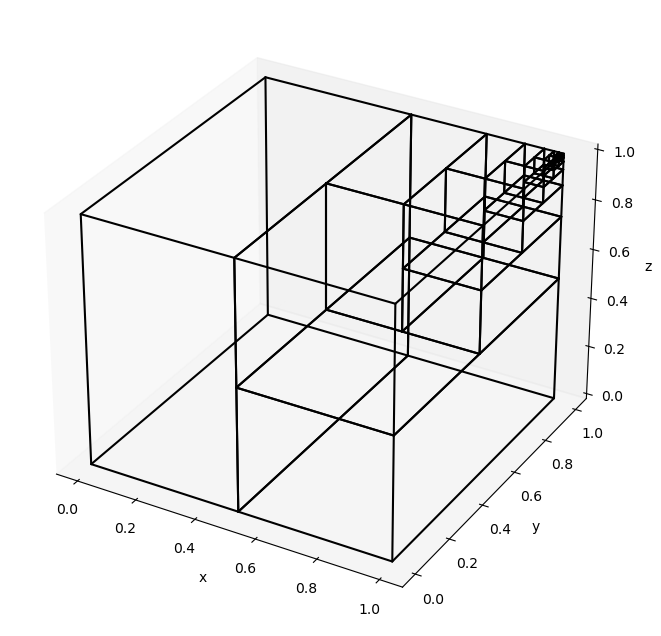

In [527]:
M.draw(knots=False)

In [528]:
MP.Constr.shape

(228, 168)

In [529]:
Basis, constr ,nonderivedDofs = compute_basis(MP.Constr.copy(), 1000)

114
multiply & repeat
multiply & repeat
done
14
multiply & repeat
multiply & repeat
done
4
multiply & repeat
multiply & repeat
done
3
multiply & repeat
done
1
multiply & repeat
done


In [530]:
abs(MP.Constr@Basis).max()

0.375

In [531]:
print(MP.Constr@Basis)

  (26, 63)	-0.125
  (26, 39)	-0.078125
  (26, 3)	-0.0068359375
  (26, 1)	-0.0009765625
  (26, 15)	-0.025390625
  (26, 13)	-0.013671875
  (26, 5)	-0.0146484375
  (26, 7)	-0.0205078125
  (26, 23)	-0.05078125
  (26, 31)	-0.0703125
  (26, 47)	-0.15625
  (26, 55)	-0.1875
  (118, 111)	-0.125
  (118, 87)	-0.078125
  (118, 77)	-0.1015625
  (118, 63)	-0.037109375
  (118, 55)	-0.0126953125
  (118, 47)	-0.01611328125
  (118, 39)	-0.014404296875
  (118, 31)	-0.0057373046875
  (118, 23)	-0.00531005859375
  (118, 15)	-0.004241943359375
  (118, 13)	-0.002227783203125
  (118, 7)	-0.0017547607421875
  (118, 5)	-0.0007476806640625
  :	:
  (159, 103)	-0.375
  (216, 63)	-0.125
  (216, 39)	-0.078125
  (216, 3)	-0.0068359375
  (216, 1)	-0.0009765625
  (216, 15)	-0.025390625
  (216, 13)	-0.013671875
  (216, 5)	-0.0146484375
  (216, 7)	-0.0205078125
  (216, 23)	-0.05078125
  (216, 31)	-0.0703125
  (216, 47)	-0.15625
  (216, 55)	-0.1875
  (218, 1)	-0.001953125
  (218, 3)	-0.013671875
  (218, 13)	-0.02734375
  

In [532]:
Basis.shape

(168, 168)

In [533]:
MP.Constr

<228x168 sparse matrix of type '<class 'numpy.float64'>'
	with 676 stored elements in Compressed Sparse Row format>

In [534]:
nonderivedDofs

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  11,  13,  15,  21,  23,  31,  39,  47,  55,  63,  77,  79,  87,  95, 103, 111, 125, 127, 135, 143, 151, 159, 167])

In [535]:
print(constr)

  (0, 1)	-0.0009765625
  (0, 3)	-0.0068359375
  (0, 5)	-0.0146484375
  (0, 7)	-0.0205078125
  (0, 13)	-0.013671875
  (0, 15)	-0.025390625
  (0, 23)	-0.05078125
  (0, 31)	-0.0703125
  (0, 39)	-0.078125
  (0, 47)	-0.15625
  (0, 55)	-0.1875
  (0, 63)	-0.125
  (1, 1)	-0.0001068115234375
  (1, 3)	-0.0011138916015625
  (1, 5)	-0.0007476806640625
  (1, 7)	-0.0017547607421875
  (1, 13)	-0.002227783203125
  (1, 15)	-0.004241943359375
  (1, 23)	-0.00531005859375
  (1, 31)	-0.0057373046875
  (1, 39)	-0.014404296875
  (1, 47)	-0.01611328125
  (1, 55)	-0.0126953125
  (1, 63)	-0.037109375
  (1, 77)	-0.1015625
  :	:
  (5, 111)	-0.25
  (6, 1)	-0.0009765625
  (6, 3)	-0.0068359375
  (6, 5)	-0.0146484375
  (6, 7)	-0.0205078125
  (6, 13)	-0.013671875
  (6, 15)	-0.025390625
  (6, 23)	-0.05078125
  (6, 31)	-0.0703125
  (6, 39)	-0.078125
  (6, 47)	-0.15625
  (6, 55)	-0.1875
  (6, 63)	-0.125
  (7, 1)	-0.001953125
  (7, 3)	-0.013671875
  (7, 5)	-0.029296875
  (7, 7)	-0.041015625
  (7, 13)	-0.02734375
  (7, 15)

In [536]:
A=basis_for_nullspace(constr,basis_for_nullspace_of_dense_LU)

In [537]:
print(A)

  (0, 0)	1.0
  (1, 2)	1.0
  (2, 4)	1.0
  (3, 6)	1.0
  (4, 8)	1.0
  (5, 9)	1.0
  (6, 10)	1.0
  (7, 11)	1.0
  (8, 12)	1.0
  (9, 14)	1.0
  (10, 16)	1.0
  (11, 17)	1.0
  (12, 18)	1.0
  (13, 19)	1.0
  (14, 20)	1.0
  (15, 21)	1.0
  (16, 22)	1.0
  (17, 24)	1.0
  (18, 25)	1.0
  (19, 26)	1.0
  (20, 27)	1.0
  (21, 28)	1.0
  (22, 29)	1.0
  (23, 30)	1.0
  (24, 32)	1.0
  :	:
  (157, 47)	0.375
  (158, 1)	-16.0
  (158, 3)	1.0
  (158, 55)	0.046875
  (159, 1)	1.0
  (159, 3)	-0.2
  (159, 63)	0.003125
  (160, 1)	1.0
  (160, 3)	-0.14285714285714285
  (160, 77)	0.0005151098901098901
  (161, 1)	1.0
  (161, 3)	-0.14285714285714285
  (161, 79)	0.000744047619047619
  (162, 1)	1.0
  (162, 3)	-0.14285714285714285
  (162, 87)	0.000669642857142857
  (163, 1)	1.0
  (163, 3)	-0.14285714285714285
  (163, 95)	0.0003348214285714285
  (164, 1)	1.0
  (164, 3)	-0.14285714285714285
  (164, 103)	0.00027901785714285713
  (165, 1)	1.0
  (165, 3)	-0.14285714285714288
  (165, 111)	0.00041852678571428575


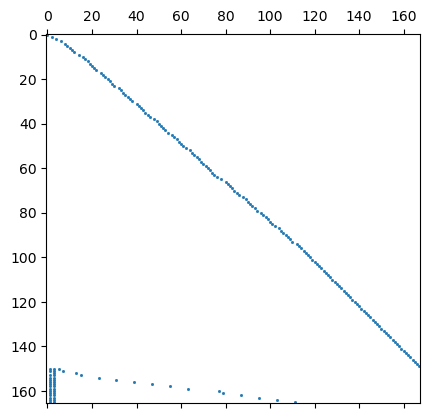

In [538]:
spy(A,markersize=1)

In [231]:
constr.shape

(4, 96)

In [188]:
constr@A.T

ValueError: dimension mismatch

In [172]:
A.shape

(167, 168)

In [173]:
Basis=Basis@A.T

In [174]:
MP.Constr.shape

(228, 168)

In [175]:
Basis.shape

(168, 167)

In [176]:
Basis[:,nonderivedDofs]

IndexError: index (167) out of range

In [156]:
abs(MP.Constr@Basis).max()

0.0

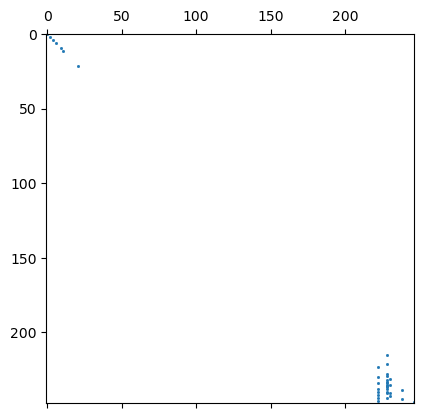

In [157]:
spy(Basis,markersize=1e0)

In [402]:
Constr=scipy.sparse.rand(5,8, density=0.5)

In [403]:
Constr.A

array([[0.     , 0.65302, 0.     , 0.     , 0.76212, 0.     , 0.99477, 0.     ],
       [0.41712, 0.02494, 0.     , 0.     , 0.15541, 0.81304, 0.     , 0.88219],
       [0.     , 0.     , 0.     , 0.55785, 0.34187, 0.     , 0.     , 0.     ],
       [0.47057, 0.12023, 0.     , 0.     , 0.67779, 0.     , 0.59852, 0.10272],
       [0.88086, 0.14463, 0.05539, 0.     , 0.04161, 0.     , 0.     , 0.15758]])

In [33]:
scipy.sparse.spdiags((a==0)*(-1)+(a!=0),0,6,6).A

array([[-1,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  1]])

In [404]:
a=(Constr>0.5+1e-12).sum(axis=1).A.ravel()

In [405]:
a

array([3, 2, 1, 2, 1])